<a href="https://colab.research.google.com/github/emms204/FellowShip.AI/blob/main/Felllowship_AIChallenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import copy

In [3]:
seed = 1
torch.manual_seed(seed)
np.random.seed(seed)

In [4]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagewoof-320.tgz

--2022-12-17 15:19:37--  https://s3.amazonaws.com/fast-ai-imageclas/imagewoof-320.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.164.48, 52.217.201.232, 52.216.36.104, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.164.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 328003750 (313M) [application/x-tar]
Saving to: ‘imagewoof-320.tgz.1’

imagewoof-320.tgz.1 100%[===================>] 312.81M  7.05MB/s    in 36s     

2022-12-17 15:20:14 (8.70 MB/s) - ‘imagewoof-320.tgz.1’ saved [328003750/328003750]



In [5]:
!tar -xvf /content/imagewoof-320.tgz

Streaming output truncated to the last 5000 lines.
imagewoof-320/train/n02088364/n02088364_11835.JPEG
imagewoof-320/train/n02088364/n02088364_1980.JPEG
imagewoof-320/train/n02088364/n02088364_17534.JPEG
imagewoof-320/train/n02088364/n02088364_13179.JPEG
imagewoof-320/train/n02088364/n02088364_9520.JPEG
imagewoof-320/train/n02088364/n02088364_8011.JPEG
imagewoof-320/train/n02088364/n02088364_14055.JPEG
imagewoof-320/train/n02088364/n02088364_3071.JPEG
imagewoof-320/train/n02088364/n02088364_16588.JPEG
imagewoof-320/train/n02088364/n02088364_16207.JPEG
imagewoof-320/train/n02088364/n02088364_13712.JPEG
imagewoof-320/train/n02088364/n02088364_1503.JPEG
imagewoof-320/train/n02088364/n02088364_18343.JPEG
imagewoof-320/train/n02088364/n02088364_72.JPEG
imagewoof-320/train/n02088364/n02088364_5871.JPEG
imagewoof-320/train/n02088364/n02088364_8739.JPEG
imagewoof-320/train/n02088364/n02088364_232.JPEG
imagewoof-320/train/n02088364/n02088364_10523.JPEG
imagewoof-320/train/n02088364/n02088364_842

In [6]:
train_path = '/content/imagewoof-320/train'
val_path = '/content/imagewoof-320/val'

In [7]:
trans = transforms.Compose([
    transforms.Resize((480,480)),
    transforms.ToTensor(),
    # transforms.Normalize(
    #     mean=[0.5, 0.5, 0.5],
    #     std=[0.5, 0.5, 0.5])
])

In [8]:
train = datasets.ImageFolder(train_path,transform=trans)
test = datasets.ImageFolder(val_path,transform=trans)

In [9]:
train_dl = DataLoader(train,batch_size=8,shuffle=True,num_workers=2,pin_memory=True)
valid_dl = DataLoader(test,batch_size=8,shuffle=False,num_workers=2,pin_memory=True)

In [10]:
labels = {0:'Australian terrier',1:'Border terrier',2:'Samoyed',3:'Beagle',4:'Shih-Tzu',5:'English foxhound', 
          6:'Rhodesian ridgeback',7:'Dingo',8:'Golden retriever',9:'Old English',10:'sheepdog'}

##Data Visualization

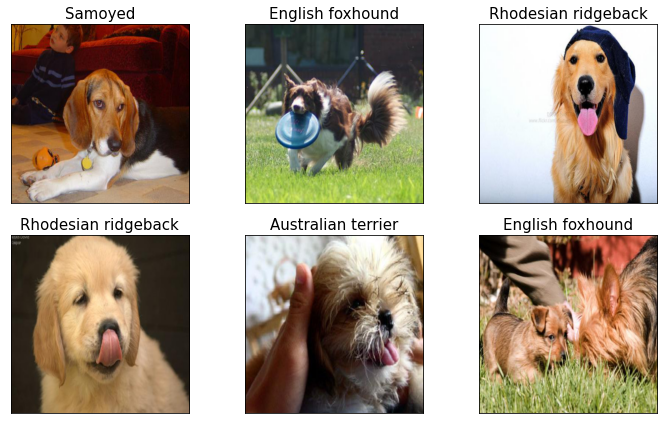

In [63]:
dataiter = iter(train_dl)
images, label = next(dataiter)

fig = plt.figure(figsize=(10, 6))
for i in range(6):
  ax = fig.add_subplot(2, 3, i+1)
  ax.set_xticks([]) 
  ax.set_yticks([])
  ax.imshow(images[i].numpy().transpose((1, 2, 0)))
  ax.set_title(f'{labels[label[i].item()]}', size=15)

plt.tight_layout()
plt.show()

##Modelling

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [12]:
def train_model(model,criterion,optimizer,num_epochs,train_dl,valid_dl):
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  val_preds = []

  for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs -1}')
    print('-' * 10)

    #Training Phase
    model.train()
    running_loss_T = 0.0
    running_corrects_T = 0
    for inputs, labels in train_dl:
      inputs, labels = inputs.to(device),labels.to(device)
      labels = labels.to(torch.int64)
      optimizer.zero_grad()
      outputs = model(inputs)
      _, preds = torch.max(outputs,1)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss_T += loss.item() * inputs.size(0)
      running_corrects_T += torch.sum(preds==labels.data)

    #Validation Phase
    model.eval()
    running_loss_V = 0.0
    running_corrects_V = 0
    with torch.no_grad():
      ts_preds = []
      for inputs, labels in valid_dl:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.to(torch.int64)
        outputs = model(inputs)
        _, preds = torch.max(outputs,1)
        val_loss = criterion(outputs, labels)
        running_loss_V += val_loss.item() * inputs.size(0)
        running_corrects_V += torch.sum(preds==labels.data)

    #scheduler.step(val_loss)
    Train_loss = running_loss_T/len(train_dl.dataset)
    Train_acc = running_corrects_T.double() / len(train_dl.dataset)
    Valid_loss = running_loss_V/len(valid_dl.dataset)
    Valid_acc = running_corrects_V.double() / len(valid_dl.dataset)

    print(f'Train Loss: {Train_loss:.4f} Train Acc: {Train_acc:.4f} Valid Loss: {Valid_loss:.4f} Valid Acc: {Valid_acc:.4f}')
    #print(f"lr:{optimizer.param_groups[0]['lr']}")
    if Valid_acc > best_acc:
      best_acc = Valid_acc
      best_model_wts = copy.deepcopy(model.state_dict())

  model.load_state_dict(best_model_wts)
  return model




#Using Pretrained weights

In [ ]:
class Model(nn.Module):
  def __init__(self,base_model):
    super().__init__()
    self.md = base_model
  def forward(self,x):
    x = self.md(x)
    return x

In [ ]:
from torchvision.models import resnet50
model_resnet = resnet50(weights='IMAGENET1K_V1')
for param in model_resnet.parameters():
  param.requires_grad = False

num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs,10)

In [ ]:
model_rs = Model(model_resnet)
model_rs = model_rs.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_rs.parameters(),lr=1e-4)

In [ ]:
num_epochs = 10
hist_vl = train_model(model_rs,criterion,optimizer,num_epochs,train_dl,valid_dl)

Epoch 0/9
----------
Train Loss: 0.8960 Train Acc: 0.8407 Valid Loss: 0.4130 Valid Acc: 0.8960
Epoch 1/9
----------
Train Loss: 0.3735 Train Acc: 0.9150 Valid Loss: 0.3052 Valid Acc: 0.9040
Epoch 2/9
----------
Train Loss: 0.2957 Train Acc: 0.9213 Valid Loss: 0.2730 Valid Acc: 0.9180
Epoch 3/9
----------
Train Loss: 0.2678 Train Acc: 0.9253 Valid Loss: 0.2671 Valid Acc: 0.9120
Epoch 4/9
----------
Train Loss: 0.2472 Train Acc: 0.9255 Valid Loss: 0.2643 Valid Acc: 0.9160
Epoch 5/9
----------
Train Loss: 0.2397 Train Acc: 0.9274 Valid Loss: 0.2560 Valid Acc: 0.9260
Epoch 6/9
----------
Train Loss: 0.2264 Train Acc: 0.9271 Valid Loss: 0.2333 Valid Acc: 0.9220
Epoch 7/9
----------
Train Loss: 0.2191 Train Acc: 0.9324 Valid Loss: 0.2644 Valid Acc: 0.9100
Epoch 8/9
----------
Train Loss: 0.2168 Train Acc: 0.9331 Valid Loss: 0.2145 Valid Acc: 0.9240
Epoch 9/9
----------
Train Loss: 0.2042 Train Acc: 0.9371 Valid Loss: 0.2409 Valid Acc: 0.9180


#Training from Scratch without Pretrained Weights

In [ ]:
from torchvision.models import resnet50
model_resnet2 = resnet50()
num_ftrs = model_resnet2.fc.in_features
model_resnet2.fc = nn.Linear(num_ftrs,10)

In [ ]:
model_rs2 = model_resnet2.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_rs2 = torch.optim.Adam(model_rs2.parameters(),lr=1e-4)

In [ ]:
num_epochs = 10
hist_rs = train_model(model_rs2,criterion,optimizer_rs2,num_epochs,train_dl,valid_dl)

Epoch 0/9
----------
Train Loss: 2.1680 Train Acc: 0.1935 Valid Loss: 2.1266 Valid Acc: 0.2400
Epoch 1/9
----------
Train Loss: 1.9768 Train Acc: 0.2791 Valid Loss: 1.9094 Valid Acc: 0.3300
Epoch 2/9
----------
Train Loss: 1.8215 Train Acc: 0.3456 Valid Loss: 1.7805 Valid Acc: 0.3760
Epoch 3/9
----------
Train Loss: 1.6844 Train Acc: 0.4036 Valid Loss: 1.7728 Valid Acc: 0.3640
Epoch 4/9
----------
Train Loss: 1.5545 Train Acc: 0.4456 Valid Loss: 1.5724 Valid Acc: 0.4300
Epoch 5/9
----------
Train Loss: 1.4072 Train Acc: 0.5039 Valid Loss: 1.6559 Valid Acc: 0.4260
Epoch 6/9
----------
Train Loss: 1.2657 Train Acc: 0.5576 Valid Loss: 1.4539 Valid Acc: 0.4660
Epoch 7/9
----------
Train Loss: 1.1257 Train Acc: 0.6105 Valid Loss: 1.5044 Valid Acc: 0.4920
Epoch 8/9
----------
Train Loss: 0.9614 Train Acc: 0.6658 Valid Loss: 1.5019 Valid Acc: 0.5120
Epoch 9/9
----------
Train Loss: 0.7766 Train Acc: 0.7273 Valid Loss: 1.4582 Valid Acc: 0.5400


#Progressive Resizing With Pretrained Models

In [ ]:
from torchvision.models import resnet50
model_resnet = resnet50(weights='IMAGENET1K_V1')
for param in model_resnet.parameters():
  param.requires_grad = False

num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs,10)

In [ ]:
class Model_pr(nn.Module):
  def __init__(self,base_model,image_size):
    super().__init__()
    self.base_model = base_model
    self.image_size = image_size 

  def forward(self,x):
    x = transforms.functional.resize(x,[self.image_size,self.image_size])
    x = self.base_model(x)

    return x

In [ ]:
model_prs = Model_pr(model_resnet,224).to(device)

In [ ]:
criterion_prs = nn.CrossEntropyLoss()
optimizer_prs = torch.optim.Adam(model_prs.parameters(),lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_prs,
                                                       mode='min',
                                                       factor=0.1,
                                                       patience=2,
                                                       threshold_mode='abs')

In [ ]:
num_epochs = 20
hist_prs = train_model(model_prs,criterion_prs,optimizer_prs,scheduler,num_epochs,train_dl,valid_dl)

Epoch 0/19
----------
Train Loss: 0.2134 Train Acc: 0.9488 Valid Loss: 0.2678 Valid Acc: 0.9180
Epoch 1/19
----------
Train Loss: 0.2000 Train Acc: 0.9495 Valid Loss: 0.2600 Valid Acc: 0.9200
Epoch 2/19
----------
Train Loss: 0.1876 Train Acc: 0.9521 Valid Loss: 0.2541 Valid Acc: 0.9200
Epoch 3/19
----------
Train Loss: 0.1780 Train Acc: 0.9546 Valid Loss: 0.2467 Valid Acc: 0.9220
Epoch 4/19
----------
Train Loss: 0.1710 Train Acc: 0.9548 Valid Loss: 0.2365 Valid Acc: 0.9240
Epoch 5/19
----------
Train Loss: 0.1653 Train Acc: 0.9552 Valid Loss: 0.2402 Valid Acc: 0.9240
Epoch 6/19
----------
Train Loss: 0.1602 Train Acc: 0.9552 Valid Loss: 0.2494 Valid Acc: 0.9200
Epoch 7/19
----------
Train Loss: 0.1565 Train Acc: 0.9562 Valid Loss: 0.2408 Valid Acc: 0.9280
Epoch 8/19
----------
Train Loss: 0.1510 Train Acc: 0.9586 Valid Loss: 0.2293 Valid Acc: 0.9300
Epoch 9/19
----------
Train Loss: 0.1494 Train Acc: 0.9582 Valid Loss: 0.2318 Valid Acc: 0.9320
Epoch 10/19
----------
Train Loss: 0.148

In [ ]:
torch.save(hist_prs.state_dict(),'/content/RESNET_50_224.pth')

In [ ]:
model_prs2 = Model_pr(model_resnet,256).to(device)
model_prs2.load_state_dict(torch.load('/content/RESNET_50_224.pth'),strict=False)

<All keys matched successfully>

In [ ]:
criterion_prs2 = nn.CrossEntropyLoss()
optimizer_prs2 = torch.optim.Adam(model_prs2.parameters(),lr=1e-4)

In [ ]:
num_epochs = 10
hist_prs2 = train_model(model_prs2,criterion_prs2,optimizer_prs2,scheduler,num_epochs,train_dl,valid_dl)

Epoch 0/9
----------
Train Loss: 0.1221 Train Acc: 0.9646 Valid Loss: 0.2119 Valid Acc: 0.9340
Epoch 1/9
----------
Train Loss: 0.1217 Train Acc: 0.9638 Valid Loss: 0.2077 Valid Acc: 0.9280
Epoch 2/9
----------
Train Loss: 0.1174 Train Acc: 0.9655 Valid Loss: 0.2062 Valid Acc: 0.9320
Epoch 3/9
----------
Train Loss: 0.1167 Train Acc: 0.9654 Valid Loss: 0.2423 Valid Acc: 0.9220
Epoch 4/9
----------
Train Loss: 0.1133 Train Acc: 0.9661 Valid Loss: 0.2107 Valid Acc: 0.9340
Epoch 5/9
----------
Train Loss: 0.1125 Train Acc: 0.9652 Valid Loss: 0.2111 Valid Acc: 0.9280
Epoch 6/9
----------
Train Loss: 0.1110 Train Acc: 0.9663 Valid Loss: 0.2216 Valid Acc: 0.9260
Epoch 7/9
----------
Train Loss: 0.1088 Train Acc: 0.9672 Valid Loss: 0.2147 Valid Acc: 0.9320
Epoch 8/9
----------
Train Loss: 0.1077 Train Acc: 0.9672 Valid Loss: 0.2010 Valid Acc: 0.9300
Epoch 9/9
----------
Train Loss: 0.1096 Train Acc: 0.9676 Valid Loss: 0.2300 Valid Acc: 0.9280


In [ ]:
torch.save(hist_prs2.state_dict(),'/content/RESNET_50_256.pth')

In [ ]:
model_prs3 = Model_pr(model_resnet,320).to(device)
model_prs3.load_state_dict(torch.load('/content/RESNET_50_256.pth'),strict=False)

<All keys matched successfully>

In [ ]:
criterion_prs3 = nn.CrossEntropyLoss()
optimizer_prs3 = torch.optim.Adam(model_prs3.parameters(),lr=1e-4)

In [ ]:
num_epochs = 10
hist_prs3 = train_model(model_prs3,criterion_prs3,optimizer_prs3,scheduler,num_epochs,train_dl,valid_dl)

Epoch 0/9
----------
Train Loss: 0.1155 Train Acc: 0.9703 Valid Loss: 0.2072 Valid Acc: 0.9320
Epoch 1/9
----------
Train Loss: 0.1131 Train Acc: 0.9707 Valid Loss: 0.1992 Valid Acc: 0.9260
Epoch 2/9
----------
Train Loss: 0.1102 Train Acc: 0.9705 Valid Loss: 0.2033 Valid Acc: 0.9300
Epoch 3/9
----------
Train Loss: 0.1081 Train Acc: 0.9708 Valid Loss: 0.2073 Valid Acc: 0.9320
Epoch 4/9
----------
Train Loss: 0.1061 Train Acc: 0.9713 Valid Loss: 0.2110 Valid Acc: 0.9300
Epoch 5/9
----------
Train Loss: 0.1045 Train Acc: 0.9713 Valid Loss: 0.2228 Valid Acc: 0.9180
Epoch 6/9
----------
Train Loss: 0.1029 Train Acc: 0.9715 Valid Loss: 0.2047 Valid Acc: 0.9320
Epoch 7/9
----------
Train Loss: 0.1029 Train Acc: 0.9709 Valid Loss: 0.2076 Valid Acc: 0.9320
Epoch 8/9
----------
Train Loss: 0.0994 Train Acc: 0.9713 Valid Loss: 0.2006 Valid Acc: 0.9300
Epoch 9/9
----------
Train Loss: 0.0976 Train Acc: 0.9724 Valid Loss: 0.2011 Valid Acc: 0.9260


#SCA-CNN

# <font color = "seagreen">Modeling</font>

Here, we've tried to integrate a **Multi-Attention** mechanism on the top of base model. In essence, we've added [**Convolutional Block Attention Module (CBAM)**](https://arxiv.org/abs/1807.06521) and [**DeepMoji**](https://github.com/bfelbo/DeepMoji/blob/master/deepmoji/attlayer.py)'s attention mechanism in parallel and merge them at the end. Additionally, we've modified a bit of the **CBAM** mechanism. Also the end part of **spatial** module of **CBAN** by integrating the **Global Weighted Average Pooling (GWAP)** method, mathematically as follows. The idea of **GWAP** is inspired from [Dr. Kevin](https://www.kaggle.com/kmader)'s great work, [check](https://www.kaggle.com/kmader/attention-on-pretrained-vgg16-for-bone-age).


$$ \text{GWAP}(x, y, d) = \frac{ \sum\limits_{x}\sum\limits_{y} \text{Attention}(x,y,d) \text{Feature}(x,y,d)} {\sum\limits_{x}\sum\limits_{y} \text{Attention}(x,y,d)} $$

[Attention Learning in CV (!ViT) - Details](https://www.kaggle.com/c/cassava-leaf-disease-classification/discussion/203083). 

In [143]:
from torchvision.models import resnet50
model_resnet = resnet50(weights='IMAGENET1K_V1')
for param in model_resnet.parameters():
  param.requires_grad = False

model = nn.Sequential(*list(model_resnet.children())[:-1])

In [144]:
class SpatialAttentionModule(nn.Module):
  def __init__(self, kernel_size=3):
    super().__init__()
    self.conv1 = nn.Conv2d(2,64,kernel_size,1,padding='same')
    self.conv2 = nn.Conv2d(64,32,kernel_size,1,padding='same')
    self.conv3 = nn.Conv2d(32,16,kernel_size,1,padding='same')
    self.conv4 = nn.Conv2d(16,1,1,1,padding='same')
        
  def forward(self,x):
    x = x.permute(0,2,3,1)
    avg_out = torch.mean(x,axis=3)
    max_out = torch.max(x,axis=3).values
    x = torch.stack([avg_out,max_out],dim=3)
    x = x.permute(0,3,1,2)
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    return torch.sigmoid(self.conv4(x))

In [145]:
class ChannelAttentionModule(nn.Module):
  def __init__(self):
    super(ChannelAttentionModule, self).__init__()
    self.conv2 = nn.Conv2d(2048,2048,kernel_size=1,stride=1,padding='same')

  def forward(self, inputs):
    # compute gap and gmp pooling 
    gapavg = F.adaptive_avg_pool2d(inputs,(1,1)).squeeze()
    gmpmax = F.adaptive_max_pool2d(inputs,(1,1)).squeeze()
    gapavg = gapavg.unsqueeze(1)
    gapavg = gapavg.unsqueeze(1)
    gmpmax = gmpmax.unsqueeze(1)
    gmpmax = gmpmax.unsqueeze(1)
    # forward passing to the respected layers
    gapavg, gmpmax = gapavg.permute(0,3,1,2),gmpmax.permute(0,3,1,2)
    gapavg_out = F.elu(self.conv2(gapavg))
    gmpmax_out = F.elu(self.conv2(gmpmax))
    return torch.sigmoid(gapavg_out + gmpmax_out)

In [146]:
class AttentionWeightedAverage2D(nn.Module):
  def __init__(self):
    super(AttentionWeightedAverage2D, self).__init__()
    ws = torch.Tensor(2048,1)
    self.W = nn.Parameter(ws)
    nn.init.normal_(self.W,mean=0.0,std=0.01)

  def forward(self, x):
    x = x.permute(0,2,3,1)
    logits = torch.matmul(x,self.W)
    logits = torch.reshape(logits, (x.shape[0],x.shape[1],x.shape[2]))
    ai = torch.exp(logits - torch.amax(logits,dim=(1,2),keepdims=True))
    att_weights = ai / (torch.sum(ai,dim=(1,2),keepdims=True) + 1e-07)
    weighted_input = x * att_weights.unsqueeze(-1)
    result = torch.sum(weighted_input,dim=(1,2))
    return result

In [168]:
class RANZCRClassifier(nn.Module):
    def __init__(self):
      super(RANZCRClassifier, self).__init__()
      self.base = nn.Sequential(*list(model_resnet.children())[:-2])
      self.batch_norm  = nn.BatchNorm1d(2048)
      self.dropout = nn.Dropout(p=0.5)
        
      # Neck
      self.can_module   = ChannelAttentionModule()
      self.san_module_x = SpatialAttentionModule()
      self.san_module_y = SpatialAttentionModule()
      self.awn_module   = AttentionWeightedAverage2D()
        
      # Head
      self.dense_layer = nn.Linear(2048,512)
      self.classifier  = nn.Linear(512,10)

    def forward(self, x,training=False):
      #Base Inputs
      base_out = self.base(x)

      #Attention Modules 1
      #Channel Attention + Spatial Attention
      canx = self.can_module(base_out)*base_out
      spnx = self.san_module_x(canx)*canx
      spny = self.san_module_y(canx)

      # Global Weighted Average Pooling
      gapx = F.adaptive_avg_pool2d(spnx,(1,1)).squeeze()
      wvgx = F.adaptive_avg_pool2d(spny,(1,1)).squeeze()
      gapavg = (gapx + wvgx.unsqueeze(-1))/2

      # Attention Modules 2
      # Attention Weighted Average (AWG)
      awgavg = self.awn_module(base_out)
      # Summation of Attentions
      attns_adds = torch.add(gapavg, awgavg)
        
      # Tails
      x = self.batch_norm(attns_adds)
      x = F.relu(self.dense_layer(x))
      if training==True:
        x = self.dropout(x)
      x = torch.sigmoid(self.classifier(x))
      
      # if not training:
      #   return x, base_out, canx
      return x


In [169]:
Model_SCA = RANZCRClassifier().to(device)

In [170]:
criterion_sca = nn.CrossEntropyLoss()
optimizer_sca = torch.optim.Adam(Model_SCA.parameters(),lr=1e-4)

In [171]:
num_epochs = 10
hist_sca = train_model(Model_SCA,criterion_sca,optimizer_sca,num_epochs,train_dl,valid_dl)

Epoch 0/9
----------
Train Loss: 1.5927 Train Acc: 0.8912 Valid Loss: 1.5314 Valid Acc: 0.9100
Epoch 1/9
----------
Train Loss: 1.5324 Train Acc: 0.9197 Valid Loss: 1.5308 Valid Acc: 0.9100
Epoch 2/9
----------
Train Loss: 1.5271 Train Acc: 0.9230 Valid Loss: 1.5178 Valid Acc: 0.9180
Epoch 3/9
----------
Train Loss: 1.5227 Train Acc: 0.9240 Valid Loss: 1.5152 Valid Acc: 0.9220
Epoch 4/9
----------
Train Loss: 1.5208 Train Acc: 0.9259 Valid Loss: 1.5188 Valid Acc: 0.9180
Epoch 5/9
----------
Train Loss: 1.5189 Train Acc: 0.9299 Valid Loss: 1.5208 Valid Acc: 0.9300
Epoch 6/9
----------
Train Loss: 1.5171 Train Acc: 0.9301 Valid Loss: 1.5181 Valid Acc: 0.9260
Epoch 7/9
----------
Train Loss: 1.5152 Train Acc: 0.9344 Valid Loss: 1.5195 Valid Acc: 0.9240
Epoch 8/9
----------
Train Loss: 1.5120 Train Acc: 0.9346 Valid Loss: 1.5160 Valid Acc: 0.9240
Epoch 9/9
----------
Train Loss: 1.5125 Train Acc: 0.9370 Valid Loss: 1.5119 Valid Acc: 0.9320
